# Optimizing models using the PyTorch JIT

*Thomas Viehmann, MathInf GmbH*

Today we look at TorchScript, the language implemented by the PyTorch JIT ("Just in Time compiler"), PyTorch's solution for deployment and model optimization. 
We can use it to export models to work beyond Python, e.g. on mobile or embedded platforms, or just to escape the infamous Python Global Interpreter Lock during computation. This is possibly the more well-known application.

But the JIT also lends itself to the implementation _holistic_ optimizations that consider several operations at once. This is  as opposed to just writing a better implementation of any given PyTorch operation, although the JIT works for these, too, as we will see.

We will start with a high-level overview of how PyTorch and the JIT work to then dive into the how it enables compiling fused kernels to optimize models at run time.

*Sidenote:* If you want to take a look at exporting models, do check out Chapter 15 of our [book](https://www.manning.com/books/deep-learning-with-pytorch), from which I also took some diagrams below. There we introduce the JIT with a view towards running the model in C++ and on mobile. The book also as a comprehensive introduction from everything PyTorch to how to represent data and a detailed account of project to build an AI detecting cancerous lung nodules.

This tutorial has been prepared in the context of work I did for AMD. Thank you!

**Note:** This is the Notebook version of a [blog post](https://lernapparat.de/jit-optimization-intro/) on the subject.

The first thing we want to do when considering how the JIT works is consider the structure of PyTorch.

<img src="Ch15_F4_PyTorch_calling_pytorch.svg"/>
(image from Deep Learning with PyTorch)

PyTorch most prominently is a PyTorch library, I call this part classic PyTorch. Some parts are implemented in Python (e.g. the `torch.nn` modules and the optimizers), but the compute functions (like `torch.matmul`) are provided as a Python C++ extension.

Looking a bit closer, this Python C++ extension is a thin wrapper around PyTorch's C++ library _LibTorch_. That in turn uses the ATen tensor library which itself dispatches into various backends.

The PyTorch JIT now implements a virtual machine that takes in TorchScript programs (typically created through the `torch.jit` ) and runs them by calling into LibTorch itself, circumventing the Python parts.

The JIT also is extendable by defining _Custom Ops_, we'll get back to this. To run PyTorch-exported programs in Torch Mobile or Torch Serving, the typical thing is to implement a wrapper around the JIT api to load and run modules.



## TorchScript

Now that we know that we want to run our model in the JIT execution, we should see how to get our model into TorchScript, the form the JIT can process.

*Sidenote:* TorchScript is used simultaneously for the language - mostly a typed subset of Python - and the representation (intermediate - IR).

There are two main ways of achieving this (but they can be mixed), _scripting_ and _tracing_. Let's look at them.

In [1]:
import sys
#sys.path.insert(0, '/home/tv/pytorch/pytorch/build/lib.linux-x86_64-3.9/')
import torch

%matplotlib inline
from matplotlib import pyplot
import numpy

assert torch.cuda.is_available(), "Some examples need the GPU"
torch.cuda.get_device_name()


'Vega 20 [Radeon VII]'

## Scripting

Scripting compiles (mostly) a subset of Python.
It takes the Python source code and transforms it. 
"Here is what the function should do", just like normal programming.


In [2]:
@torch.jit.script
def fn(x):
    return x * 2

In [3]:
fn, fn.graph

(<torch.jit.ScriptFunction at 0x7ff36e888f90>,
 graph(%x.1 : Tensor):
   %2 : int = prim::Constant[value=2]() # <ipython-input-2-6dcc6c3c1c8e>:3:15
   %3 : Tensor = aten::mul(%x.1, %2) # <ipython-input-2-6dcc6c3c1c8e>:3:11
   return (%3))

### Tracing

Tracing runs the code and observers the calls into PyTorch with some sample input.
"Watch me, now you know how to do the same."

In [4]:
def fn(x):
    return x * 2
fn = torch.jit.trace(fn, [torch.randn(5)])

print(fn.graph, fn.code)

graph(%x : Float(5, strides=[1], requires_grad=0, device=cpu)):
  %1 : Long(requires_grad=0, device=cpu) = prim::Constant[value={2}]() # <ipython-input-4-7d43d0af2e80>:2:0
  %2 : Float(5, strides=[1], requires_grad=0, device=cpu) = aten::mul(%x, %1) # <ipython-input-4-7d43d0af2e80>:2:0
  return (%2)
 def fn(x: Tensor) -> Tensor:
  return torch.mul(x, CONSTANTS.c0)



N.B.: The specialization for the Tensor shape isn't relevant here and will be erased e.g. during saving of the model.

### What is TorchScript?

Now that had a glimpse of TorchScript, what is it?

One important difference between TorchScript and Python is that in TorchScript everything is typed. Important
types are
- `bool`, `int`, `long`, `double` for numbers (int = 32 bit integer, long = 64 bit integer)
- `Tensor` for tensors (of arbitrary shape, dtype, ...)
- `List[T]` a list with elements fo type T (one of the above)
- Tuples are of fixed size with arbitrary but fixed element type, so e.g. `Tuple(Tensor, int)`.
- `Optional[T]` for things that can be `None`

`None` always is of type `Optional[T]` for some specific `T` (except in the rarest circumstances).

PyTorch will mostly infer the intermediate and return types, but you need to annotate any non-Tensor inputs.

(maybe move to later)
Another important difference is the binding behaviour - when a given variable name is looked up to find the associated variable. Python uses late binding. If we write a function that calls `torch.matmul` the Python interpreter will look up what `torch.matmul` is when it executes the statement in which it is used.

This is in contrast to many other languages, which use early binding, as - your guessed it - TorchScript does: When we compile a function to TorchScript, the JIT looks it up then and there and puts it into our function (it even inlines the commands, but that is another part).
*Sidenote:* And while functions are looked up early, the *operators* being executed by the PyTorch JIT are found during runtime.



### Tracing vs. Scripting

Scripting will process all code but may not understand all. This means it captures all constructs (like control flow) it understands, but it will fail if it doesn't understand something.

Tracing doesn't see anything not calling into PyTorch and will happily ignore that (e.g. control flow). This is also the reason why it will loudly complain if you have non-tensor inputs.


In [5]:
def fn(x):
    for i in range(x.dim()):
        x = x * x
    return x

script_fn = torch.jit.script(fn)
trace_fn = torch.jit.trace(fn, [torch.randn(5, 5)])

In [6]:
print(script_fn.code)

def fn(x: Tensor) -> Tensor:
  x0 = x
  for i in range(torch.dim(x)):
    x0 = torch.mul(x0, x0)
  return x0



In [7]:
print(trace_fn.code)

def fn(x: Tensor) -> Tensor:
  x0 = torch.mul(x, x)
  return torch.mul(x0, x0)



## Tracing and Scripting Modules

But our models often are not functions. What now?

With tracing, we can work just like with functions. We get a `ScriptModule` subclass that behaves much like a
`Module` with parameters, state dict etc.

In [8]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1))
    
traced_model = torch.jit.trace(model, [torch.randn(8, 1)])
type(traced_model), traced_model

(torch.jit._trace.TopLevelTracedModule,
 Sequential(
   original_name=Sequential
   (0): Linear(original_name=Linear)
   (1): ReLU(original_name=ReLU)
   (2): Linear(original_name=Linear)
 ))

Saving is a bit different, here we include the model on purpose:

In [9]:
traced_model.save('./traced_model.pt')
loaded_model = torch.jit.load('./traced_model.pt')

loaded_model(torch.randn(8,1))

tensor([[1.0100],
        [0.4957],
        [0.5004],
        [0.6980],
        [0.8027],
        [0.5387],
        [0.6841],
        [0.7053]], grad_fn=<AddBackward0>)

# Scripting Modules

Scripting modules is ... a bit tricky. We don't script the class in its entirety but instead take an instance (in particular past `__init__`) and process its data members and methods (the latters work like script functions).

In [10]:
scripted_model = torch.jit.script(model)
print(scripted_model.code)

def forward(self,
    input: Tensor) -> Tensor:
  _0 = getattr(self, "0")
  _1 = getattr(self, "1")
  _2 = getattr(self, "2")
  input0 = (_0).forward(input, )
  input1 = (_1).forward(input0, )
  return (_2).forward(input1, )



We can also look at the graph including submodules, but it gets unwieldy rather fast:

In [11]:
scripted_model.forward.inlined_graph

graph(%self : __torch__.torch.nn.modules.container.___torch_mangle_13.Sequential,
      %input.1 : Tensor):
  %2 : __torch__.torch.nn.modules.linear.___torch_mangle_10.Linear = prim::GetAttr[name="0"](%self)
  %3 : __torch__.torch.nn.modules.activation.___torch_mangle_11.ReLU = prim::GetAttr[name="1"](%self)
  %4 : __torch__.torch.nn.modules.linear.___torch_mangle_12.Linear = prim::GetAttr[name="2"](%self)
  %8 : int = prim::Constant[value=1]()
  %9 : int = prim::Constant[value=2]() # /usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1663:22
  %10 : Tensor = prim::GetAttr[name="weight"](%2)
  %11 : Tensor = prim::GetAttr[name="bias"](%2)
  %12 : int = aten::dim(%input.1) # /usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1663:7
  %13 : bool = aten::eq(%12, %9) # /usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1663:7
  %input.3 : Tensor = prim::If(%13) # /usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1663:4
    block0():
      %15 : 

# What can you do with scripted modules?

- Run them as is, bypassing Python.
  - not as much speedup as often is expected (maybe 5%-10% for some models I tested),
  - but - sometimes crucially - it avoids the dreaded Python Global Interpreter Lock (GIL), so it is useful e.g.
    for multithreaded things like serving PyTorch models.
- Export and run in C++ / Mobile / ..., export to other frameworks like [TVM](https://tvm.ai/).
- Apply holistic optimizations (this is what a submodule, the JIT fuser does).

# How the JIT works at a very high level

For the in-depth discussion of fusers it will be useful to look closer at how the JIT works under the hood.
The JIT has several phases to get us from a function to running our programs. For our purposes, we think of the following three stages:

- The first thing is to go from tracing or source to a graph.
- Then there are a number of compiler passes through the graph to go from `.graph` to an optimized graph (that can be retrieved with `.graph_for(*inputs)`. We will meet some of them in detail below.
- Finally, the `.graph` is compiled to a from of bytecode that is then executed by a virtual machine. We might hope to not meet the bytecode too often, but clearly we want this part to be fast, too. This maintains the operands on a stack and then dispatches to the various operators registered by LibTorch or the _custom operators_ that extend the JIT.

The unoptimized `.graph` is the "hosehold" format here, in particular, this is what is serialized and loading a scripted function will then have to re-do the optimizations.

## Tracing or scripting to a .graph

 When tracing a function, the LibTorch dispatcher will call a special function (found in `torch/csrc/autograd/generated/TraceTypeEverything.cpp` after you have built PyTorch) for every call of a LibTorch function. This special function  (*Sidenote*: For more on the dispatcher, see Ed Yang's excellent blog post [Let's talk about the PyTorch Dispatcher](http://blog.ezyang.com/2020/09/lets-talk-about-the-pytorch-dispatcher/).) This will record a graph node (the ones that show up in `.graph`) with source location and type information and all in a `TracingState` structure's `.graph` and in between re-dispatch to run the real LibTorch operation. This `.graph` is more or less directly what you can see as `.graph` of a traced function.

- When tracing modules, the tracer will also hook into the module `__call__` method to record the current module as the scope to capture the module structure. This is done at the Python level in the `torch.nn.Module` class, see the `_slow_forward` method there.

- When scripting a function from Python, the JIT grabs the Python source code (via the `inspect` module of the standard Python library) and then runs the Python parser from `ast` (for Abstract Syntax Tree) module. It then transforms the Python AST into a TorchScript (implemented in C++) one, from which an initial graph form that looks a lot like Python (i.e. before converting to a [static single assignment](https://en.wikipedia.org/wiki/Static_single_assignment_form) (SSA) form. Any name lookup is also done at this stage (so TorchScript is (mostly) [statically binding](https://en.wikipedia.org/wiki/Name_resolution_(programming_languages) rather than dynamically like Python), representing objects as _Sugared Values_ in between. Finally, the JIT transforms the graph into the SSA form that you can see with `.graph`.

- There is a variant of scripting that can be called directly from C++ and does not use the Python `ast` but parses Python on its own. This is used internally by `AutoDiff` but is also a neat trick to use from C++.


## Optimization passes

The JIT compiler gets us from `.graph` to what we see with `.graph_for` above by running a series of optimization (and some other) passes. This is done by the JIT's GraphExecutor (actually there are two, the "regular" one and the profiling one) on the first run or first few runs in the case of the profiling executor. The optimized graphs are cached along with the bytecode.

There are a number of passes that work and don't mess with AutoGrad like (these are not all of them also there are analysis passes for shapes and types and such)

- Eliminating dead code and common subexpressions, pre-computing things that only involve constants,
- Pooling redundant constants into single values, and some simple "pattern matching" optimizations (like eliminating  `.t().t()`),
- Unrolling small loops and batching matrix multiplications that result from unrolling loops.

If the last one looks awefully special, it is, but it is quite commonly used in recurrent networks such as LSTMs with the input weights.

As you might have guessed with the introduction, there are also some passes that can mess up AutoGrad and we can only do them if we do not require gradients or have taken of AutoGrad before. 

## Bytecode and execution

Finally, the optmized graph is lowered to bytecode and run by the virtual machine. The virtual machine can also do function calls, this is used e.g. by the fallback mechanisms of the fusers. We will not deal much with this part.

So this gives you a very high-level overview of what goes on in the JIT. As usual, things get complicated really soon and also the JIT is actively being worked on, making this a bit of a moving target in the details. 

# Excursion: GPU, efficiency, measurement

Before we discuss optimization through the JIT we have to discuss measurement. In fact, one of my many informal mottos is _It's not optimization until you measure_. I'll only discuss the most basic measurement here, PyTorch offers a capable profiling facility, too.

When you think about code being slow, it's important to figure out what is slow and why.
To my mind, a lot of measurement can be done with very basic tools, e.g. IPython's `%timeit` magic.

As GPU computation is and shold be ansynchronous, avoid unneeded synchronization points. Synchronization happens when the CPU waits for the GPU (to get the results).
- Synchronizations can happen because the program needs to know something (e.g. sizes of tensors depending on
    the input). Often, these are unavoidable.
- Typical sources of spurious synchronizations are too frequent 
    `.to(device="cpu")`, `.item()`, `.to_list()`, `print`.


If we want to time GPU kernels, we want to be sure to synchronize before taking the start and end times.
Typically, we also want to have some "warm-up", i.e. run the measured function before timing.

Let's take the uniformity loss from [Wang and Isola: Understanding Contrastive Representation Learning through Alignment and Uniformity on the Hypersphere](https://arxiv.org/abs/2005.10242) (a great paper!).

The Uniformity loss is defined as a function of the pairwise distances over a largish set of vectors.


In [12]:
def lunif(x, t=2): # copied from the paper
    sq_pdist = torch.pdist(x, p=2).pow(2)
    return sq_pdist.mul(-t).exp().mean().log()

x = torch.randn(1024, 128, device="cuda")
x /= x.norm(p=2, dim=1, keepdim=True).requires_grad_()

lunif(x)

tensor(-3.9374, device='cuda:0', grad_fn=<LogBackward>)

One would think that the specialised `pdist` function is the right tool for the job.
But is it? Let's time it.

In [13]:
def totime(fn):
    l = fn(x)
    g, = torch.autograd.grad(l, x)
    torch.cuda.synchronize()

totime(lunif) # warmup
%timeit totime(lunif)

18.6 ms ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's use $|x-y|^2 = |x|^2 + |y|^2 - 2 <x, y>$ and compare.

In [14]:
def lunif2(x, t=2):
    t=2
    xnorm = torch.norm(x, p=2, dim=1).pow(2)
    sq_pdist = xnorm[None] + xnorm[:, None] - 2 * torch.mm(x, x.t())
    exp = sq_pdist.mul(-t).exp().tril(diagonal=-1)
    N = x.size(0)
    res = exp.sum().mul(2/(N*N-N)).log()
    return res

print((lunif2(x.to(torch.double)) - lunif(x.to(torch.double))).item())

totime(lunif2)
%timeit totime(lunif2)

0.0
2.19 ms ± 9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Even though we have stark inefficiencies (like taking tril and taking a copy to do so), this is almost an order of magnitude faster!

Largely due to backward of `pdist` implementation.

## Optimization

### But Python is slow...

Uniformity loss: "what formulas you use" is the real bottleneck (unless you optimize pdist).

The "what do we compute" typically should be the first optimization target.

But when we fix the task ("what"), how can we optimize?

Conventional wisdom: **Python is slow**

- certainly, Python isn't fast (`for` loop vs C++ `for` loop)
- but, if the GPU is saturated $\Rightarrow$ Python isn't the bottleneck


### How PyTorch programs spend their time

At a very high level, you can divide time spent into these parts:
- Python program flow,
- Data "administrative overhead" (creating `Tensor` data structures, autograd `Node`s etc.),
- Data aquisition (I/O),
- Computation roughly as
  - fixed overhead (kernel launches etc.),
  - reading / writing memory,
  - "real computation".

**Thomas' rule of thumb**: As long as your operands are reasonably large (say 100s of elements, not single elements), Python and data "administrative overhead" probably isn't your main problem.

So while the JIT takes away some Python overhead, this is not spectacular optimization.
With this out of the way, let us get back to how the JIT helps us optimize things.

## An ad-hoc graph plotter (skip this)

It will be handy to draw some graphs, so here is a function that plots our graphs. It's not complete by any means, but it helps us here.

In [15]:
def make_graph(gr):
    import graphviz
    dot = graphviz.Digraph(format='svg', graph_attr={'labelloc': 't'})

    nodes = {}
    for i in gr.inputs():
        nname = i.debugName()
        label = nname.split('.')[0]
        nodes[nname] = (nname, dot)
        dot.node(nname, label, color='blue')

    unseen_ops = {'prim::ListConstruct', 'aten::index', 
                  'aten::size', 'aten::slice', 'aten::unsqueeze', 'aten::squeeze',
                  'aten::to', 'aten::view', 'aten::permute', 'aten::transpose', 'aten::contiguous',
                  'aten::permute', 'aten::Int', 'prim::TupleUnpack', 'prim::ListUnpack', 'aten::unbind',
                  'aten::select', 'aten::detach', 'aten::stack', 'aten::reshape', 'aten::split_with_sizes',
                  'aten::cat', 'aten::expand', 'aten::expand_as', 'aten::_shape_as_tensor',
                  'aten::_size_if_not_equal', 'prim::BroadcastSizes',
                  'prim::Constant',
                  }

    def process_block(nodeit, dot):
        firstnode = None
        lastnode = None
        for n in nodeit:
            k = n.kind()
            outs = list(n.outputs())
            inps = list(n.inputs())
            type_outs = [o.type().kind() for o in outs]
            type_inps = [o.type().kind() for o in inps]
            if k == 'prim::If':
                label = 'If'
                nname = outs[0].debugName()
                for i in inps:
                    src, srcdot = nodes.get(i.debugName(), (None, None))
                    if src is not None:
                        srcdot.edge(src, nname + '_in')
                dot.node(nname + '_in', 'If', shape='diamond')
                dot.node(nname, '', width='0.1', height='0.1')
                dot.edge(nname + '_in', nname, style='invis')
                nodes[nname] = (nname, dot)
                bl = list(n.blocks())
                for i, b in enumerate(bl):
                    with dot.subgraph(name=f"cluster_{nname}_{i}", graph_attr={'label':''}) as sub_dot:
                        firstnode, lastnode = process_block(b.nodes(), sub_dot)
                    dot.edge(nname + '_in', firstnode, label="yn"[i])
                    dot.edge(lastnode, nname)
                if firstnode is None:
                    firstnode = nname + '_in'
                lastnode = nname
            elif k == 'prim::DifferentiableGraph':
                label = 'DifferentiableGraph'
                nname = outs[0].debugName()
                nodes[nname] = (nname, dot)
                sg = n.g('Subgraph')
                nis = list(n.inputs())
                sgis = list(sg.inputs())
                assert len(nis) == len(sgis)
                for ni, sgi in zip(nis, sgis):
                    if ni.debugName() in nodes:
                        nodes[sgi.debugName()] = nodes[ni.debugName()]
                with dot.subgraph(name=f"cluster_{nname}", graph_attr={
                    'label': 'DifferentiableGraph', 'labelloc':'b', 'labeljust':'r'}) as sub_dot:
                    firstnode, lastnode = process_block(sg.nodes(), sub_dot)
                nos = list(n.outputs())
                sgos = list(sg.outputs())
                assert len(nos) <= len(sgos)
                for no, sgo in zip(nos, sgos):
                    if sgo.debugName() in nodes:
                        nodes[no.debugName()] = (nodes[sgo.debugName()][0], dot)
            elif k not in unseen_ops:
                if k == 'prim::CallFunction':
                    label = 'call ' + next(n.inputs()).node().s("name")
                else:
                    label = k.replace('aten::', '').replace('prim::', '')
                nname = outs[0].debugName()
                dot.node(nname, label, shape='box', style='rounded')
                for o in outs:
                    nodes[o.debugName()] = (nname, dot)
                for i in inps:
                    src, srcdot = nodes.get(i.debugName(), (None, None))
                    if src is not None:
                        srcdot.edge(src, nname)
                if firstnode is None:
                    firstnode = nname
                lastnode = nname
        return firstnode, lastnode

    process_block(gr.nodes(), dot)
    dot.node('.outputs', 'outputs', color='blue')
    for i, o in enumerate(gr.outputs()):
        src, srcdot = nodes.get(o.debugName(), (None, None))
        if src is not None:
            dot.edge(src, '.outputs')

    return dot


## Holistic Optimizations - JIT fusers

So currently the fuser is a hotspot of development, and PyTorch has no fewer than three fusers:

In [16]:
help(torch.jit.fuser)

Help on function fuser in module torch.jit._fuser:

fuser(name)
    A context manager that facilitates switching between
    backend fusers.
    
    Valid names:
    * ``fuser0`` - enables only legacy fuser
    * ``fuser1`` - enables only NNC
    * ``fuser2`` - enables only nvFuser



# How the JIT optimizes pointwise operations

<img src="iou.svg" style="float: right;" />

To get a taste of how the JIT fuser works, let us look at the intersection over union ratio for detection models.
We have a two lists of rectangles given by the top left (as x and y coordinates) and width and height.
To measure the pairwise agreement of the $i$th rectangle in the first and in the second list.
We do this by the intersection over union ratio which computes the areas of the intersection and the union of the two rectangles. The quotient of the two is between 0 (no agreement at all) and 1 (perfect agreement).

*Sidenote*: Another prominent example of pointwise operations is in LSTMs: They can be though of as two matrix multiplications followed by a series of pointwise operations for the gates. The case of LSTMs has been a show case for the JIT
[show case](https://lernapparat.de/fast-lstm-pytorch/) [for JIT](https://lernapparat.de/more-jit-optimizations/) [optimizations](https://pytorch.org/blog/optimizing-cuda-rnn-with-torchscript/).

In [17]:
def ratio_iou(x1, y1, w1, h1, x2, y2, w2, h2):
    xi = torch.max(x1, x2)                                  # Intersection left
    yi = torch.max(y1, y2)                                  # Intersection top
    wi = torch.clamp(torch.min(x1+w1, x2+w2) - xi, min=0.)  # Intersection width
    hi = torch.clamp(torch.min(y1+h1, y2+h2) - yi, min=0.)  # Intersection height
    area_i = wi * hi                                        # Area Intersection
    area_u = w1 * h1 + w2 * h2 - wi * hi                    # Area Union
    return area_i / torch.clamp(area_u, min=1e-5)           # Intersection over Union

# we make a scripted function
ratio_iou_scripted = torch.jit.script(ratio_iou)

This is a simple enough function with elementwise computation. Let us look at the function graph.

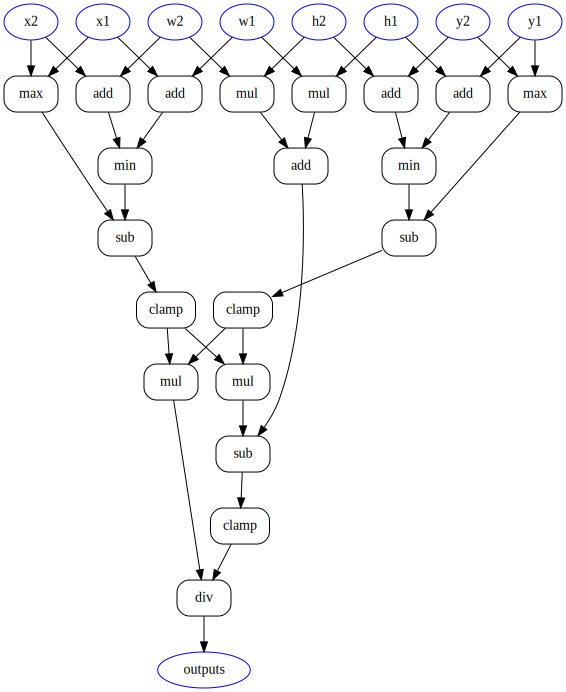

In [18]:
make_graph(ratio_iou_scripted.graph)

It is not complex as code, but it has quite a few operations. Now, in terms of execution, every of these ops launches a kernel (a function run on the GPU) that does three things:

- Load the inputs (from the incoming edges) from memory,
- compute the output,
- store the result.

These are 37 times loading inputs and 20 times storing outputs with only trivial computation.
Clearly this is heavily limited by the memory transfers, even if we can get helped by caching.

What if we could make it all into one large kernel and have 8 loads and 1 store?

This is exactly what a fuser does and it does give us a good speedup:

In [19]:
x1, y1, w1, h1, x2, y2, w2, h2 = torch.randn(8, 100, 1000, device='cuda').exp()

def take_time(fn):
    _ = fn(x1, y1, w1, h1, x2, y2, w2, h2)
    torch.cuda.synchronize()

take_time(ratio_iou) # warmup
%timeit take_time(ratio_iou)

for i in range(2):
    take_time(ratio_iou_scripted)
%timeit take_time(ratio_iou_scripted)

161 µs ± 938 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
38.2 µs ± 485 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


We can see in the graph specialised for the inputs which operations are fused:

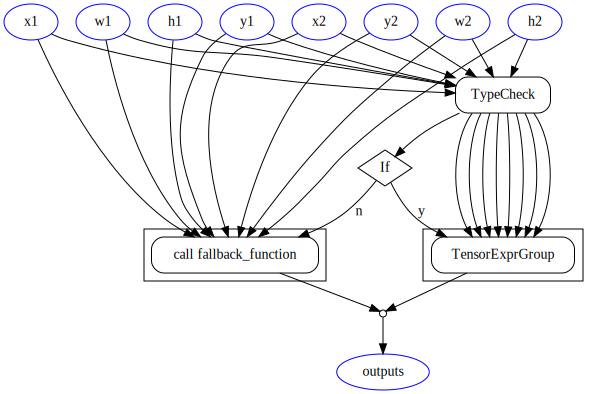

In [20]:
make_graph(ratio_iou_scripted.graph_for(x1, y1, w1, h1, x2, y2, w2, h2))


Aha, so we do some type check and if that returns OK, we run a `TensorExprGroup`, which will be executed as one kernel. We keep a fallback just in case.
In the text representation, we can actually see the `TensorExprGroup` and we can see which operations are fused:

In [21]:
ratio_iou_scripted.graph_for(x1, y1, w1, h1, x2, y2, w2, h2)

graph(%x1.1 : Tensor,
      %y1.1 : Tensor,
      %w1.1 : Tensor,
      %h1.1 : Tensor,
      %x2.1 : Tensor,
      %y2.1 : Tensor,
      %w2.1 : Tensor,
      %h2.1 : Tensor):
  %112 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %113 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %114 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %115 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %116 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %117 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %118 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %119 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %120 : bool = prim::TypeCheck(%w2.1, %h2.1, %w1.1, %h1.1, %y2.1, %y1.1, %x2.1, %x1.1)
  %121 : Tensor = prim::If(%120)
    block0():
      %68 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0) 

We will look in some detail how these things work, but the core idea is that operations of the `TensorExprGroup` here will be compiled into a single kernel that then computes the result from the inputs in one go.

## How the Fusers Work at a High Level

At a high level, PyTorch's fusers work in three parts:

- In a fusion JIT compiler pass, the operations that can be fused are arranged in a fusion group. By looking at which operations can be fused, we get a good glimpse of what the fusers (think) they can achieve. The classic (or legacy) PyTorch fuser only considers pointwise operations (like the IOU above, see `isSimpleMap` in `torch/csrc/jit/passes/graph_fuser.cpp`). The cuda fuser (or fuser2/nvFuser above), which is conceptually somewhat close but much more elaborate than the classic fuser also handles `sum` (see `IRParser`'s `registerJitOperator` in `torch/csrc/jit/codegen/cuda/parser.cpp`). The TensorExpr fuser (fuser1, the default) fuses pointwise and `softmax` and `log_softmax` in addition to `sum` if reduction support is enabled (see `isSupported` in `torch/csrc/jit/passes/tensorexpr_graph_fuser.cpp`). It generates a fusion group node of some sort, but, in the case of the newer two fusers also inserts a check (`TypeCheck` or ...) and an explicit fallback. Interestingly, the fusers also support `rand_like`, which is very interesting and useful functionality for things like dropout.

- At some point (typically the first invocation of the fusion group), it compiles a kernel for the computation. Typically this is specific to (some aspects of) the type and shape of the inputs. For the GPU, the fusers emit HIP/CUDA C code and compile using the GPU RTC (run time compile) library. For the CPU the classic fuser would also use C but the TensorExpr fuser uses an LLVM backend (but note that the CPU is much less of a target and the main use case is the GPU). These kernels are cached.

- When running a fusion group (the fuser registers an operator with the JIT that is then called), the fuser needs to launch the kernel. For the newer fusers, checking whether the inputs matches expectations is done outside this node, but the classic fuser would do the fallback itself if needed.

One thing to know about the fallback is that it itself will be optimized by the PyTorch JIT. So when we run a function that has been optimized with fusions with incompatible parameters (e.g. change whether we want gradients), the faling type check would cause the JIT to call the fallback and that would then get the optmizations for these parameters (and another level of check and fallback).


### Code generation from TorchScritpt IR to GPU kernel

In addition to the operator support, the code generation is where each fuser has a different approach.

The CUDA fuser first transforms the TorchScript IR in the CudaFusionGroup to a Fusion IR.
This is then further lowered to the Kernel IR and finally translated to C++-code from which the
runtime compiler generates the kernel. The approach is conceptually relatively straightforward: there are optimizaitons how the data access is layed out and then pointwise operators are just loading, computing and storing. For reductions, there is a heuristic how to deal with the reduction axes (this is somewhat similar to TensorIterators in ATen, and, indeed the use-case is quite similar but with the compile-time vs. run-time distinction). But, as these things go, to get good results, there are quite a few things to take care of.

The TensorExpr fuser (which is inspired by the lower levels of the [Apache TVM](https://tvm.apache.org/)) translates the TorchScript IR into a sequence of [Loop-Nest](https://en.wikipedia.org/wiki/Loop_nest_optimization) statements (this is done in `torch/csrc/jit/tensorexpr/kernel.cpp`, which implements the operator processing the `TensorExprGroup` Torchscript IR node). This is the TensorExpr IR (the quickest overview over the IR node types can maybe be had by looking at `torch/csrc/jit/tensorexpr/ir_visitor.h`). They are then optimized and lowered before they are passed to the code generators (CUDA source code for the GPU or LLVM for the CPU) that write kernel functions and then compile and run them (again, with caching).


## Automatic Differentiation in TorchScript

Things are a bit more complicated if we need gradients. The default mode of the JIT is to execute the LibTorch operations and they will build an autograd graph just like in classic PyTorch. But when we want to fuse operators, things get a bit more complicated. The problem here is AutoGrad needs intermediate results to compute the backward. This is OK, but our express purpose here is to skip storing and loading the intermediate results. This is mitigated by the PyTorch JIT's own automatic differentiation (AD) mechanism, AutoDiff (as opposed to AutoGrad in PyTorch). 

We can see it in action when we re-define our function and run it with gradient-requiring inputs: we get a `DifferentiableGraph` in there and the `TensorExprGroup` is inside that (usually this would be created as part of the fallback function but to start fresh and see this better we have to re-define the function here, just re-scripting isn't enough to clear the script):

graph(%x1.1 : Tensor,
      %y1.1 : Tensor,
      %w1.1 : Tensor,
      %h1.1 : Tensor,
      %x2.1 : Tensor,
      %y2.1 : Tensor,
      %w2.1 : Tensor,
      %h2.1 : Tensor):
  %68 : Tensor = prim::DifferentiableGraph_0(%h2.1, %h1.1, %w2.1, %w1.1, %y2.1, %y1.1, %x2.1, %x1.1)
  return (%68)
with prim::DifferentiableGraph_0 = graph(%65 : Tensor,
      %70 : Tensor,
      %96 : Tensor,
      %101 : Tensor,
      %104 : Tensor,
      %106 : Tensor,
      %109 : Tensor,
      %111 : Tensor):
  %617 : int[] = aten::size(%111) # <string>:3:44
  %620 : int[] = aten::size(%109) # <string>:3:93
  %624 : int[] = aten::size(%106) # <string>:3:44
  %627 : int[] = aten::size(%104) # <string>:3:93
  %634 : int[] = aten::size(%101) # <string>:3:93
  %641 : int[] = aten::size(%96) # <string>:3:93
  %655 : int[] = aten::size(%70) # <string>:3:93
  %662 : int[] = aten::size(%65) # <string>:3:93
  %903 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %904 : Float(100, 1000, strides

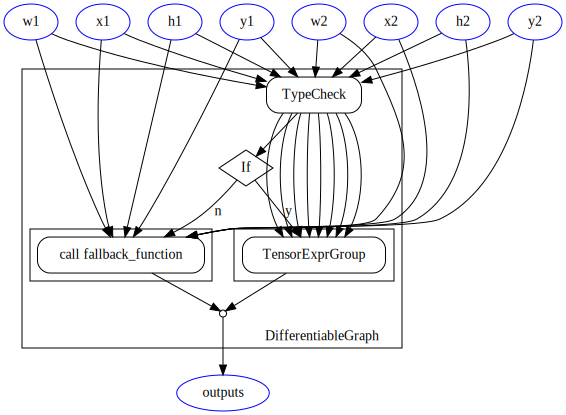

In [22]:
def ratio_iou(x1, y1, w1, h1, x2, y2, w2, h2):
    xi = torch.max(x1, x2)                                  # Intersection left
    yi = torch.max(y1, y2)                                  # Intersection top
    wi = torch.clamp(torch.min(x1+w1, x2+w2) - xi, min=0.)  # Intersection width
    hi = torch.clamp(torch.min(y1+h1, y2+h2) - yi, min=0.)  # Intersection height
    area_i = wi * hi                                        # Area Intersection
    area_u = w1 * h1 + w2 * h2 - wi * hi                    # Area Union
    return area_i / torch.clamp(area_u, min=1e-5)           # Intersection over Union

ratio_iou_scripted = torch.jit.script(ratio_iou)

x1, y1, w1, h1, x2, y2, w2, h2 = torch.randn(8, 100, 1000, device='cuda', requires_grad=True).exp()

for i in range(10):
    ratio_iou_scripted.graph_for(x1, y1, w1, h1, x2, y2, w2, h2)
print(ratio_iou_scripted.graph_for(x1, y1, w1, h1, x2, y2, w2, h2))
make_graph(ratio_iou_scripted.graph_for(x1, y1, w1, h1, x2, y2, w2, h2))

To understand why this is, we need to look at how AutoDiff works. It has roughly three stages:

- The first part of AutoDiff is a pass that creates these differentiable graphs (in the optimizations, notably before the fusing). AutoDiff has a catalogue of operations for which it can compute backwards (*Sidenote*: with their own derivative definition which could potentially differ from the AutoGrad one) it will move those into the `DifferentiableGraph`.

- Then, when we run a graph containing `DifferentiableGraph` nodes (i.e. during the forward pass), the second part of AutoDiff will compute the gradient by going through the nodes of the forward graph. This is a form of source-to-source differentiation (but in contrast to classic symbolic differentiation, it is specialized to autograd-style jacobian-vector-products). This can amend the forward to output intermediates that are then captured for the backward, similar to the `save_for_backward` mechanism in an `autograd.Function` (you can see that the `TensorExprGroup` now returns a lot more values and the `DifferentiableGraph` itself adds all these sizes.

- Finally, the PyTorch AutoGrad(!) mechanism is used by making a `DifferentiableGraphBackward` node that holds on to the intermediate values and, when backward is called, runs the backward graph constructed in the previous step (including letting the JIT optimize it, potentially fusing operations etc.).

What is it with these sizes then? The convenient broadcasting semantics cause PyTorch to implicitly expand operands to (mostly) binary operations. But these expansions have a gradient operation associated with them - a summation of any broadcast dimensions. These size operations check whether broadcasting has happened (i.e. the output shape is large than the input for a binary operation) and if so record the target size for the summation (and `None` if no summation is needed thanks to the `aten::_size_if_not_equal` operation).

There is another thing to note here: The JIT currently does not have a terribly smart logic to decide which things to capture and which things might be as well re-computed (e.g. done manually, one might well choose to recompute all the intermediates of our little function instead of capturing the values), but will mimic what AutoGrad does (defined by the AutoDiff backward specifications).

In [23]:
x1, y1, w1, h1, x2, y2, w2, h2 = torch.randn(8, 100, 1000, device='cuda', requires_grad=True).exp()

def take_time(fn):
    _ = fn(x1, y1, w1, h1, x2, y2, w2, h2)
    torch.cuda.synchronize()

take_time(ratio_iou) # warmup
%timeit take_time(ratio_iou)

for i in range(2):
    take_time(ratio_iou_scripted)
%timeit take_time(ratio_iou_scripted)

221 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
91.5 µs ± 115 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## The Profiling Executor

We mentioned that the JIT fusers will specialze on detailed tensor type informaition. How does it get this information? It is through the Profiling Executor that is in charge of running the JITed graphs.

The profiling executor will record tensor type information (dtype, strides, sizes, requires gradient) in its profiling phase (the first few invocations). This is done by inserting special `prim::profile` nodes into the graph which then run an operator collecting and aggregating this information. Currently, it runs one profiling run, but this is configurable. Then it uses this information to implement optimizations. (*Sidenote*: Lest you should be thinking of taking time measurements when hearing profiling - I sure did - this does not seem to be done here, currently.)

Traditionally, the same thing (get tensor type information attached to every value) has been done by propagating the types from the inputs through the graph. While this works great in general, it soon hits limitations, e.g. for convolutions the output shape (and thus precise type information) depends on the value (not even just the type) of e.g. the padding input. This means that unless we detect that the output-shaping inputs are constants *and* have some way of accessing type propagation, we do not know the output shape. (*Sidenote*: The same topic is also addressed by people interested in type-checking tensor programs who coordinate on the Python [typing sig mailing list](https://mail.python.org/archives/list/typing-sig@python.org/).) My best guess on the design choice here is that this is the reason we instead observe shapes during runtime (my impression is that PyTorch operations would ideally provide type propagation information, but that is could be me).

So when the JIT fuser passes mentioned above go to work, they find these typing annotations on all tensor values and can adjust.

One interesting aspects about the type expectations encoded by `TypeCheck` for the TensorExpr fuser and `CudaFuserGuard` for the CUDA fuser. (*Sidenote* Iterestingly, `TypeCheck` is wired into the JIT interpreter and JIT type system, while the `CudaFuserGuard` is implemented as a regular operator and implemented "manually" in a function `complyWith` in `torch/csrc/jit/codegen/cuda/interface.cpp`.) While they both nail the tensor shape and layout, the CUDA fuser will use the same kernel on tensors of different sizes as long as the contiguity pattern (i.e. that there are no gaps in the storage between the values of the tensor, e.g. from slicing) is the same.   


## Looking at fallback graphs

We mentioned the importance of fallbacks and how fallbacks are again optimized. But we have yet to see it.
Sadly, the JIT's Python interface is lacking or, hopefully, lagging a bit.

But we can hack around this by building our own little PyTorch extension that provides the missing functionality.
Again, I recommend to skip this bit on first reading and revisit if you really want to know about types in the JIT (that would be another tutorial).

In [24]:
csrc = """
#include <torch/extension.h>

using ::c10::Type;
using ::torch::jit::FunctionType;

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  py::class_<FunctionType, Type, std::shared_ptr<FunctionType>>(m, "FunctionType")
      .def("name", [](const std::shared_ptr<FunctionType>& self) {
        return self->function()->name();
      })
      .def(
          "get_debug_state",
          [](const std::shared_ptr<FunctionType>& self) {
            return self->function()->get_executor().getDebugState();
          })
      .def("optimized_graph", [](const std::shared_ptr<FunctionType>& self) {
        return self->function()->optimized_graph();
      });
}
"""
import torch.utils.cpp_extension
ext = torch.utils.cpp_extension.load_inline("functiontype_ext",[csrc], verbose=True)


def find_function_types(graph_or_block, function_types=None):
    if function_types is None:
        function_types = []
    for n in graph_or_block.nodes():
        if n.kind() == 'prim::Constant':
            t = n.output().type()
            if t.kind() == 'FunctionType':
                function_types.append(t)
        else:
            for b in n.blocks():
                find_function_types(b, function_types=function_types)
            if n.hasAttribute('Subgraph'):
                find_function_types(n.g('Subgraph'), function_types=function_types)
    return function_types

def get_function_graphs(gr):
    return {t.name(): list(t.get_debug_state().execution_plans.values())[0].graph for t in find_function_types(gr)}


Using /home/tv/.cache/torch_extensions as PyTorch extensions root...
Emitting ninja build file /home/tv/.cache/torch_extensions/functiontype_ext/build.ninja...
Building extension module functiontype_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module functiontype_ext...


With this, we can now extract the fallback. Let us run our function a few times, first without needing gradients and then with needing gradients.

The original graph is the part that doesn't need gradients, as could be expected.

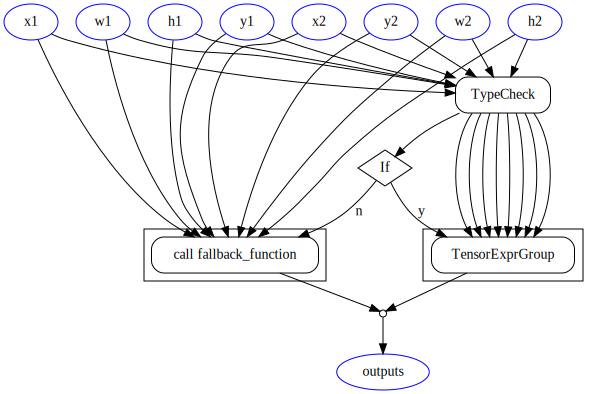

In [25]:
def ratio_iou(x1, y1, w1, h1, x2, y2, w2, h2):
    xi = torch.max(x1, x2)                                  # Intersection left
    yi = torch.max(y1, y2)                                  # Intersection top
    wi = torch.clamp(torch.min(x1+w1, x2+w2) - xi, min=0.)  # Intersection width
    hi = torch.clamp(torch.min(y1+h1, y2+h2) - yi, min=0.)  # Intersection height
    area_i = wi * hi                                        # Area Intersection
    area_u = w1 * h1 + w2 * h2 - wi * hi                    # Area Union
    return area_i / torch.clamp(area_u, min=1e-5)           # Intersection over Union

ratio_iou_scripted = torch.jit.script(ratio_iou)

x1, y1, w1, h1, x2, y2, w2, h2 = torch.randn(8, 100, 1000, device='cuda').exp()

for i in range(10):
    ratio_iou_scripted.graph_for(x1, y1, w1, h1, x2, y2, w2, h2)

x1, y1, w1, h1, x2, y2, w2, h2 = torch.randn(8, 100, 1000, device='cuda', requires_grad=True).exp()
for i in range(10):
    ratio_iou_scripted.graph_for(x1, y1, w1, h1, x2, y2, w2, h2)

gr = torch.jit.last_executed_optimized_graph()

make_graph(gr)

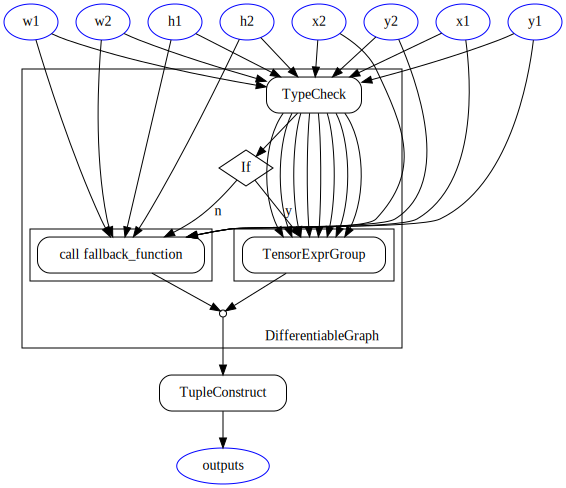

In [26]:
gr_fb1 = get_function_graphs(gr)['fallback_function']
make_graph(gr_fb1)

We can take this to several levels, but when we get an "internal assert failed" error regarding a missing optimized plan, it means that we have reached the end of the *optimized* fallback passes.

In [27]:
gr_fb2 = get_function_graphs(gr_fb1)['fallback_function']

RuntimeError: optimized_plan_ INTERNAL ASSERT FAILED at "../torch/csrc/jit/runtime/profiling_graph_executor_impl.cpp":551, please report a bug to PyTorch. 

We can inspect the unoptimized fallback, even if it may seem counterintuitive to the uninitiated like us that the unoptimized graph should be accessed via `optimized_graph` (Also note that the type annotations in the fallback branch are bogus. Oh well.):

In [28]:
find_function_types(gr_fb1)[0].optimized_graph()

graph(%0 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0),
      %1 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0),
      %2 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0),
      %3 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0),
      %4 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0),
      %5 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0),
      %6 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0),
      %7 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0)):
  %11 : int = prim::Constant[value=1]()
  %10 : float = prim::Constant[value=0.]()
  %9 : None = prim::Constant()
  %8 : float = prim::Constant[value=1.0000000000000001e-05]()
  %xi.4 : Tensor = aten::max(%7, %6) # <ipython-input-25-071038d7fdab>:2:9
  %yi.4 : Tensor = aten::max(%5, %4) # <ipython-input-25-071038d7fdab>:3:9
  %14 : Tensor = aten::add(%7, %2

## How we could go at benchmarking

We can now pitch the various fusers against each other if we want. We abuse the context manager in a non-contextmanagery way. Note that we do not time the backwards here, but it would be straightforward to do, too.

In [29]:
for rq in [False, True]:
    for fuser in [None, "fuser1", "fuser2"]:
        if fuser is not None:
            c = torch.jit.fuser(fuser)        
            c.__enter__()
        
        def ratio_iou(x1, y1, w1, h1, x2, y2, w2, h2):
            xi = torch.max(x1, x2)                                  # Intersection left
            yi = torch.max(y1, y2)                                  # Intersection top
            wi = torch.clamp(torch.min(x1+w1, x2+w2) - xi, min=0.)  # Intersection width
            hi = torch.clamp(torch.min(y1+h1, y2+h2) - yi, min=0.)  # Intersection height
            area_i = wi * hi                                        # Area Intersection
            area_u = w1 * h1 + w2 * h2 - wi * hi                    # Area Union
            return area_i / torch.clamp(area_u, min=1e-5)           # Intersection over Union

        ratio_iou_scripted = torch.jit.script(ratio_iou) if fuser is not None else ratio_iou
            

        x1, y1, w1, h1, x2, y2, w2, h2 = torch.randn(8, 100, 1000, device='cuda', requires_grad=rq).exp()
    
        print(f"fuser: {fuser}, requires gradient: {rq}")
        for i in range(10):
            take_time(ratio_iou_scripted)

        %timeit take_time(ratio_iou_scripted)


fuser: None, requires gradient: False
159 µs ± 457 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
fuser: fuser1, requires gradient: False
37.1 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
fuser: fuser2, requires gradient: False
47 µs ± 166 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
fuser: None, requires gradient: True
221 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
fuser: fuser1, requires gradient: True
92.7 µs ± 197 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
fuser: fuser2, requires gradient: True
106 µs ± 242 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Doing funny things to kick the tires a bit

If you followed along, you will have noticed that the order of kernels to try depends on how we have called our scripted function before. This can lead to somewhat funny effects.

One thing is that whether we end up running a `DifferentiableGraph` (and computing the intermediates) depends on what we did during the profiling and the fallback mechanisms for the fusion groups.
In fact, there are bugs to be found (reported as [#49299](https://github.com/pytorch/pytorch/issues/49299)) where whether we get gradient requiring outputs does not match what we feed into the scripted function:

In [30]:
for fuser in ["fuser1", "fuser2"]:
    for rq in [True, False]:
        c = torch.jit.fuser(fuser)
        c.__enter__()

        def ratio_iou(x1, y1, w1, h1, x2, y2, w2, h2):
            xi = torch.max(x1, x2)                                  # Intersection left
            yi = torch.max(y1, y2)                                  # Intersection top
            wi = torch.clamp(torch.min(x1+w1, x2+w2) - xi, min=0.)  # Intersection width
            hi = torch.clamp(torch.min(y1+h1, y2+h2) - yi, min=0.)  # Intersection height
            area_i = wi * hi                                        # Area Intersection
            area_u = w1 * h1 + w2 * h2 - wi * hi                    # Area Union
            return area_i / torch.clamp(area_u, min=1e-5)           # Intersection over Union

        ratio_iou_scripted = torch.jit.script(ratio_iou)

        x1, y1, w1, h1, x2, y2, w2, h2 = torch.randn(8, 100, 1000, device='cuda', requires_grad=not rq).exp()
        for i in range(10):
            ratio_iou_scripted.graph_for(x1, y1, w1, h1, x2, y2, w2, h2)
        x1, y1, w1, h1, x2, y2, w2, h2 = torch.randn(8, 100, 1000, device='cuda', requires_grad=rq).exp()
        print("fuser:", fuser, "input requires grad:", x1.requires_grad, "output requires grad:", ratio_iou_scripted(x1, y1, w1, h1, x2, y2, w2, h2).requires_grad)


fuser: fuser1 input requires grad: True output requires grad: True
fuser: fuser1 input requires grad: False output requires grad: True
fuser: fuser2 input requires grad: True output requires grad: True
fuser: fuser2 input requires grad: False output requires grad: True


Another fun thing to try is what happens when the profiling runs see different tensor sizes (this is a real thing, e.g. for Neural Machine Translation or other NLP applications).

Do change the fuser between `fuser1` and `fuser2` here. We see that the CUDA fuser can handle both sizes with the same kernel while the TensorExpr fuser decides to not optimize this path.


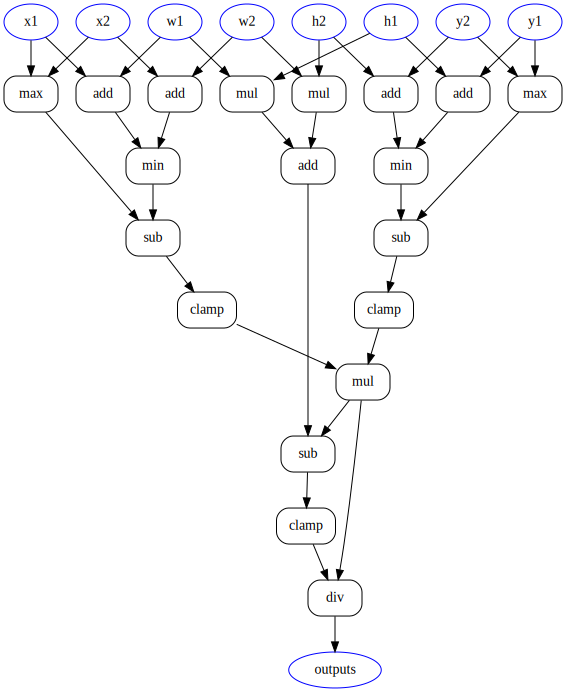

In [31]:
c = torch.jit.fuser("fuser1")
c.__enter__()
torch._C._jit_set_num_profiled_runs(2)

def ratio_iou(x1, y1, w1, h1, x2, y2, w2, h2):
    xi = torch.max(x1, x2)                                  # Intersection left
    yi = torch.max(y1, y2)                                  # Intersection top
    wi = torch.clamp(torch.min(x1+w1, x2+w2) - xi, min=0.)  # Intersection width
    hi = torch.clamp(torch.min(y1+h1, y2+h2) - yi, min=0.)  # Intersection height
    area_i = wi * hi                                        # Area Intersection
    area_u = w1 * h1 + w2 * h2 - wi * hi                    # Area Union
    return area_i / torch.clamp(area_u, min=1e-5)           # Intersection over Union

ratio_iou_scripted = torch.jit.script(ratio_iou)

inputs1 = torch.randn(8, 100, 1000, device='cuda').exp()
inputs2 = torch.randn(8, 101, 1000, device='cuda').exp()

for i in range(10):
    ratio_iou_scripted.graph_for(*inputs1)
    ratio_iou_scripted.graph_for(*inputs2)
    
make_graph(ratio_iou_scripted.graph_for(*inputs1))



## Getting more debug output

When we run the JIT on the command line, we can make use of its [debug logging facility](https://github.com/pytorch/pytorch/blob/master/torch/csrc/jit/OVERVIEW.md#jit-logging) to watch its parts in action more closely. 

The fusers also have various debugging facilities. The TensorExpr one uses the debug logging facility (grep for `GRAPH_` in `torch/csrc/jit/tensorexpr/`) and the CUDA one uses environment variables starting with `PYTORCH_CUDA_FUSER` (grep for that in `torch/csrc/jit/codegen/cuda/`).

## Conclusion

In this piece, we saw a bit how the JIT works, with a focus on the parts that make fusion optimizations possible and took a dive from a very high level to experimentation that try to show how some internals work.
I hope you enjoyed this tour. As always your feedback is appreciated: <tv@lernapparat.de>.

*Sidenote*: There also is a more general technical overview in the file [`torch/csrc/jit/OVERVIEW.md`](https://github.com/pytorch/pytorch/blob/master/torch/csrc/jit/OVERVIEW.md) in the JIT directory of the PyTorch source code) and various bits of documentation in `.md` files throughout the source as well as in comments in the source.

